In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ase.io import read, write
from rascal.representations import SphericalInvariants as SOAP
from sklearn.kernel_ridge import KernelRidge
import pickle
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species

In [2]:
def center_shifts(s):
    elements = [1, 6, 7]
    names = ['glycine_alpha', 'glycine_beta', 'glycine_gamma']
    for el in elements:
        for name in names:
            s[name][el] = np.mean(s[name][el]) - s[name][el]
    return s


shifts = {
    'glycine_alpha': {
        1: np.array([4.2, 3.1, 8.4]),
        6: np.array([176.5, 43.4]),
        7: np.array([32.3])
    },
    'glycine_beta': {
        1: np.array([2.5, 2.2, 7.4]),
        6: np.array([175.5, 43.2]),
        7: np.array([31.8])
    },
    'glycine_gamma': {
        1: np.array([3.3, 3.1, 8.8]),
        6: np.array([174.5, 42.4]),
        7: np.array([32.9])
    }
}

shifts = center_shifts(shifts)
shifts = center_shifts(shifts)

In [3]:
path_to_file = "PI_NVT/glycine_shieldings/"
path_to_init_file = "PI_NVT/"
colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [4]:
base_fn = lambda poly: path_to_file + f'pi_nvt_lmp_glycine_{poly}_300K_00_w_cs.xyz'
alpha_traj = read(base_fn('alpha'),':')
gamma_traj = read(base_fn('gamma'),':')
beta_traj = read(base_fn('beta'),':')



base_init_fn = lambda poly: path_to_init_file + f'glycine_{poly}/{poly}_init.xyz'
alpha_shieldings = read(base_init_fn("alpha"), ":" )[0].get_array("shieldings")
beta_shieldings = read(base_init_fn("beta"), ":" )[0].get_array("shieldings")
gamma_shieldings = read(base_init_fn("gamma"), ":" )[0].get_array("shieldings")

In [96]:
def process(traj, shieldings, soap, sp, X, zeta):
    nsp = []

    for frame in traj:
        frame.wrap(eps=1E-10)
        #frame.set_array("center_atoms_mask", None)

        frame.set_array('center_atoms_mask', np.zeros(frame.get_global_number_of_atoms(), dtype=bool))

        mask_center_atoms_by_species(frame, species_select=[sp,])

        nsp.append(np.sum(frame.get_array('center_atoms_mask')))

    nbatch   = 10000

    ibatch = [0]
    jbatch = []
    
    nbatch = min(nbatch, len(traj))

    for ib in range( int(np.sum(nsp)/nbatch + 0.5)):
        ifrm = 0
        msp = 0
        while msp < (ib + 1) * nbatch:
            msp = np.sum(nsp[:ifrm])
            ifrm += 1
            if ifrm == len(traj):
                ifrm += 1
                break
        jbatch.append(ifrm)
        ibatch.append(ifrm)

    number = traj[0].numbers
    no_atoms = np.sum(frame.get_array("center_atoms_mask"))

    batch_size = 0
    KNM_sum = np.zeros((no_atoms, X.shape[0]))

    # predict for test frames
    for ib in range(int(np.sum(nsp)/nbatch + 0.5)):

        partial_traj = traj[ ibatch[ib] : jbatch[ib] ]

        Y = soap.transform(partial_traj).get_features(soap)
        XY = X.dot(Y.T)
        KNM = XY.T**zeta

        KNM = KNM.reshape(len(partial_traj), no_atoms, KNM.shape[1])

        KNM_sum += np.sum(KNM, axis=0)
        batch_size +=  len(partial_traj)
    
    KNM_averaged = KNM_sum/batch_size

    types = shieldings[np.where(number == sp)[0]] 
    
    output_cs = []
    output_KNM = []

    output_cs_dict = {}
    output_KNM_dict = {}

    for type in np.unique(types):
        output_cs_dict[type] = np.array(np.mean([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==sp, shieldings == type)))[0]] for frame in traj], 0))
        output_KNM_dict[type] = np.array(KNM_averaged[np.where((types == type))[0],:])
        
    
    for type in np.unique(types):
        output_cs.append(np.mean(np.concatenate([frame.arrays['CS'][np.where((np.logical_and(frame.numbers==sp, shieldings == type)))[0]] for frame in traj])))
        output_KNM.append(np.mean(KNM_averaged[np.where((types == type))[0],:] , axis=0))
    

    return np.array(output_cs), np.array(output_KNM), output_cs_dict, output_KNM_dict 


# 3 fold model with 2 glycines as train and 1 as test set
def pred_3_folds(X_train, X_test, y_train, y_test, separate_models = True):

    alphas = np.logspace(-8, 4)

    # RMSE for 3 H shieldings of the test set (H1, H2 and H3) 
    # 6 Hs in train set (i.e. 2 of each shielding type)
    errors = np.zeros(len(alphas))

    errors_train = np.zeros(len(alphas))

    # RSE for separately for all three Hs (H1, H2, H3) of the test set 
    errors_sep = np.zeros((len(alphas), len(y_test)))

    # RSE for separately for all three Hs (H1, H2, H3) of the test set with training models separately for all 3 Hs (H1, H2, H3) 
    # train sets (2 Hs per train set)
    errors_sep_sep = np.zeros((len(alphas), len(y_test)))

    
    for ai, alpha in enumerate(alphas):
        reg = KernelRidge(alpha=alpha, kernel="cosine")
        reg.fit(X_train, y_train)
        errors[ai] = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
        errors_train[ai] = np.sqrt(mean_squared_error(y_train, reg.predict(X_train)))
        errors_sep[ai] = [np.sqrt(mean_squared_error(i, j)) for i, j in zip( y_test, reg.predict(X_test) )]
        
        if separate_models:
            for i in range(len(y_test)):
                reg = KernelRidge(alpha=alpha, kernel="cosine")
                reg.fit( X_train[(i, i + len(y_test)), :] , np.take(y_train, [i, i + len(y_test)]).reshape(-1, 1))
                errors_sep_sep[ai][i] =  np.sqrt( mean_squared_error( y_test[i], reg.predict(X_test)[i] ) ) 


    return alphas, errors, errors_sep, errors_sep_sep, errors_train

def pred_model(X_train, X_test, y_train, alpha):
    reg = KernelRidge(alpha=alpha, kernel="cosine")
    reg.fit(X_train, y_train)

    return reg.predict(X_test)


def pred_3_folds_validated(X_train, X_test, y_train, y_test):


    alphas = np.logspace(-8, 4)
    errors = np.zeros(len(alphas))

    for i in range(2):
        j = (i + 1)%2
        X_val = X_train[i*len(y_test):i*len(y_test) + len(y_test), :]
        X_train_fold = X_train[j*len(y_test):j*len(y_test) + len(y_test), :]
        y_val = y_train[i*len(y_test):i*len(y_test) + len(y_test)]
        y_train_fold = y_train[j*len(y_test):j*len(y_test) + len(y_test)]
    
        for ai, alpha in enumerate(alphas):
            reg = KernelRidge(alpha=alpha, kernel="cosine")
            reg.fit(X_train_fold, y_train_fold)
            errors[ai] += np.sqrt(mean_squared_error(y_val, reg.predict(X_val)))

    alpha_val = np.argmin(errors)

    reg = KernelRidge(alpha=alphas[alpha_val], kernel="cosine")
    reg.fit(X_train, y_train)

    final_error  = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))


    return final_error 

In [62]:
compound = "glycine"
sp = 1


with open('/home/lumiaro/Documents/master_project/average_trajectories/glycine_test/glycine_models/' + compound + '_' + str(sp) + '.pickle','rb') as f:
    [soap, kern, feat, weig, alpha] = pickle.load(f)

X = feat.get_features()
zeta = kern._kwargs["zeta"]


# download and average SOAPs and shieldings for all three glycines
cs_alpha_1, X_alpha_1, cs_alpha_1_dict, X_alpha_1_dict = process(alpha_traj, alpha_shieldings, soap, sp, X, zeta)
cs_beta_1, X_beta_1 ,cs_beta_1_dict, X_beta_1_dict = process(beta_traj, beta_shieldings, soap, sp, X, zeta)
cs_gamma_1, X_gamma_1, cs_gamma_1_dict, X_gamma_1_dict = process(gamma_traj, gamma_shieldings, soap, sp, X, zeta)


In [66]:
path_to_files = "3_fold_model_files/"

# save our averaged_results
np.save(path_to_files + "Averaged_kernel_alpha_1.npy", X_alpha_1)
np.save(path_to_files + "Averaged_kernel_beta_1.npy", X_beta_1)
np.save(path_to_files + "Averaged_kernel_gamma_1.npy", X_gamma_1)

np.savetxt(path_to_files + "Averaged_cs_alpha_1.txt", cs_alpha_1)
np.savetxt(path_to_files + "Averaged_cs_beta_1.txt", cs_beta_1)
np.savetxt(path_to_files + "Averaged_cs_gamma_1.txt", cs_gamma_1)

with open("3_fold_model_files/Averaged_kernel_alpha_1_separated.pkl", 'wb') as f:
    pickle.dump(X_alpha_1_dict, f)

with open("3_fold_model_files/Averaged_kernel_beta_1_separated.pkl", 'wb') as f:
    pickle.dump(X_beta_1_dict, f)

with open("3_fold_model_files/Averaged_kernel_gamma_1_separated.pkl", 'wb') as f:
    pickle.dump(X_gamma_1_dict, f)

with open("3_fold_model_files/Averaged_cs_alpha_1_separated.pkl", 'wb') as f:
    pickle.dump(cs_alpha_1_dict, f)

with open("3_fold_model_files/Averaged_cs_beta_1_separated.pkl", 'wb') as f:
    pickle.dump(cs_beta_1_dict, f)

with open("3_fold_model_files/Averaged_cs_gamma_1_separated.pkl", 'wb') as f:
    pickle.dump(cs_gamma_1_dict, f)

In [60]:
# load stuff
path_to_files = "3_fold_model_files/"

X_alpha_1 = np.load(path_to_files + "Averaged_kernel_alpha_1.npy")
X_beta_1 = np.load(path_to_files + "Averaged_kernel_beta_1.npy")
X_gamma_1 = np.load(path_to_files + "Averaged_kernel_gamma_1.npy")

cs_alpha_1 = np.loadtxt(path_to_files + "Averaged_cs_alpha_1.txt")
cs_beta_1 = np.loadtxt(path_to_files + "Averaged_cs_beta_1.txt")
cs_gamma_1 = np.loadtxt(path_to_files + "Averaged_cs_gamma_1.txt")

with open(path_to_files + "Averaged_kernel_alpha_1_separated.pkl", 'rb') as f:
    X_alpha_1_dict = pickle.load(f)

with open(path_to_files + "Averaged_kernel_beta_1_separated.pkl", 'rb') as f:
    X_beta_1_dict = pickle.load(f)

with open(path_to_files + "Averaged_kernel_gamma_1_separated.pkl", 'rb') as f:
    X_gamma_1_dict = pickle.load(f)

with open(path_to_files + "Averaged_cs_alpha_1_separated.pkl", 'rb') as f:
    cs_alpha_1_dict = pickle.load(f)

with open(path_to_files + "Averaged_cs_beta_1_separated.pkl", 'rb') as f:
    cs_beta_1_dict = pickle.load(f)

with open(path_to_files + "Averaged_cs_gamma_1_separated.pkl", 'rb') as f:
    cs_gamma_1_dict = pickle.load(f)

1


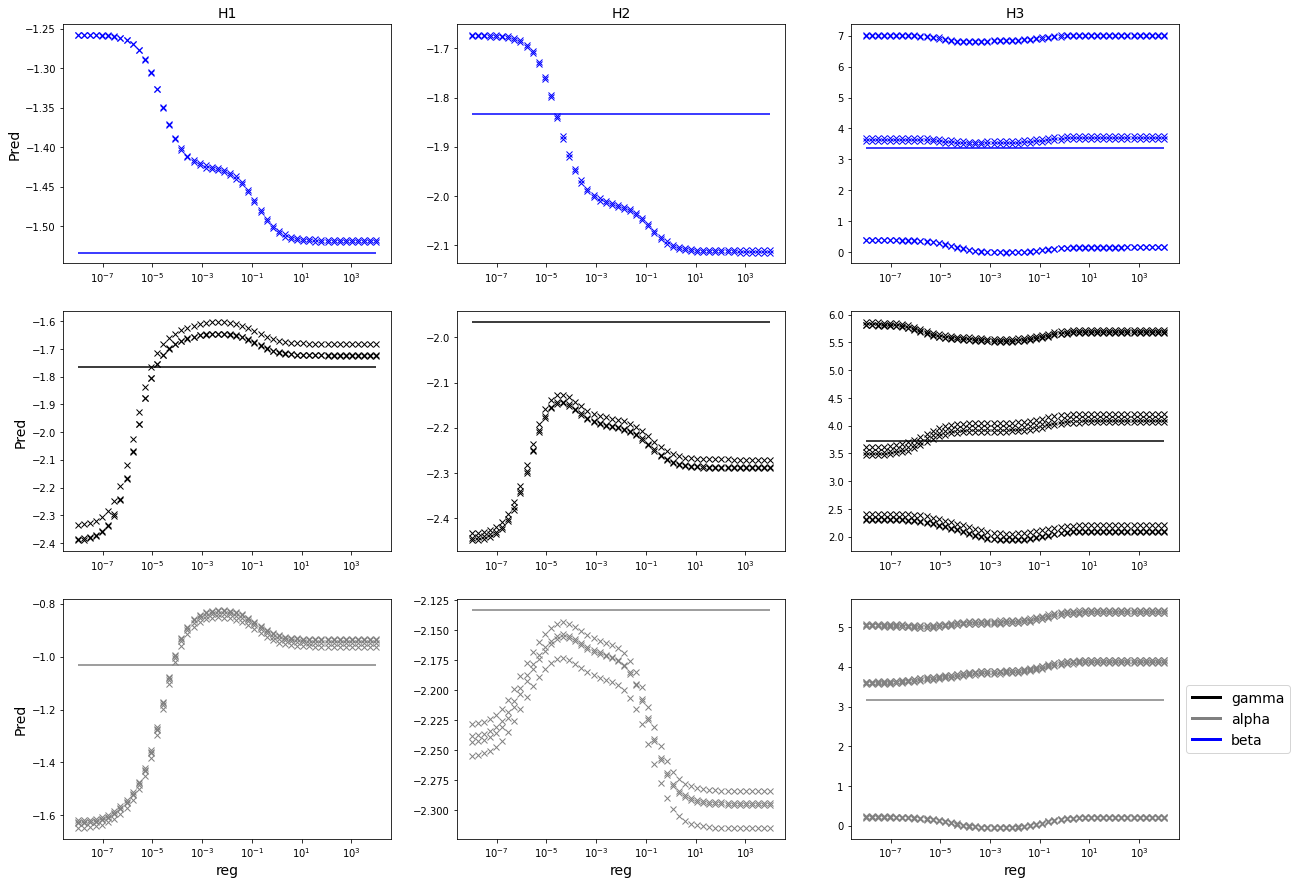

In [95]:
species = sp
print(species)

colors = ['k','grey','b','r', "pink"]

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],color=c, lw=3) for c in colors]

# compute compuational shifts from shieldings (similarly to Edgars paper)

csh_alpha_1 = cs_alpha_1.mean() - cs_alpha_1
csh_gamma_1 = cs_gamma_1.mean() - cs_gamma_1
csh_beta_1 = cs_beta_1.mean() - cs_beta_1

delta_alpha_1 = shifts['glycine_alpha'][species] - csh_alpha_1
delta_gamma_1 = shifts['glycine_gamma'][species] - csh_gamma_1
delta_beta_1 = shifts['glycine_beta'][species] - csh_beta_1

def shifts_alpha(alpha, type):
    pred_shifts_gamma = pred_model(np.array([*X_alpha_1, *X_beta_1]), X_gamma_1_dict[type], np.array([*delta_alpha_1, *delta_beta_1]).reshape(-1, 1), alpha).reshape(-1)
    pred_shifts_gamma += cs_gamma_1.mean() - cs_gamma_1_dict[type]

    pred_shifts_alpha = pred_model(np.array([*X_gamma_1, *X_beta_1]), X_alpha_1_dict[type], np.array([*delta_gamma_1, *delta_beta_1]).reshape(-1, 1), alpha).reshape(-1)
    pred_shifts_alpha += cs_alpha_1.mean() - cs_alpha_1_dict[type]

    pred_shifts_beta = pred_model(np.array([*X_alpha_1, *X_gamma_1]), X_beta_1_dict[type], np.array([*delta_alpha_1, *delta_gamma_1]).reshape(-1, 1), alpha).reshape(-1)
    pred_shifts_beta += cs_beta_1.mean() -  cs_beta_1_dict[type]

    return pred_shifts_beta, pred_shifts_alpha, pred_shifts_gamma

fig1, ax1 = plt.subplots(ncols=len(delta_alpha_1), nrows=3)
fig1.set_figheight(15)
fig1.set_figwidth(20)

alphas = np.logspace(-8, 4)

for i in range(3):
    for alpha in  alphas:
        pred_shifts_beta, pred_shifts_alpha, pred_shifts_gamma = shifts_alpha(alpha, i + 1)
        ax1[0][i].plot(alpha*np.ones(pred_shifts_beta.shape), pred_shifts_beta, "x", color= colors[2])
        ax1[1][i].plot(alpha*np.ones(pred_shifts_gamma.shape), pred_shifts_gamma, "x", color= colors[0])
        ax1[2][i].plot(alpha*np.ones(pred_shifts_alpha.shape), pred_shifts_alpha, "x", color= colors[1])
    ax1[0][i].hlines(shifts['glycine_beta'][species][i], min(alphas), max(alphas), colors[2])
    ax1[1][i].hlines( shifts['glycine_gamma'][species][i], min(alphas), max(alphas), colors[0])
    ax1[2][i].hlines(shifts['glycine_alpha'][species][i], min(alphas), max(alphas) , colors[1])
    ax1[0][i].set_title("H" + str(i + 1), fontsize=14)
    ax1[2][i].set_xlabel(r"reg", fontsize=14)
    ax1[0][i].set_xscale("log")
    ax1[1][i].set_xscale("log")
    ax1[2][i].set_xscale("log")
ax1[0][0].set_ylabel(r"Pred", fontsize=14)
ax1[1][0].set_ylabel(r"Pred", fontsize=14)
ax1[2][0].set_ylabel(r"Pred", fontsize=14)
ax1[2][2].legend(custom_lines, [ "gamma", "alpha", "beta"], fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))



1
ALPHA: 0.10189244871170454 - 0.37040665497933306  RMSE:  0.18233356829519584   BASELINE: 0.11597305181668925
BETA: 0.1164303897803836 - 0.25929375801965726  RMSE:  0.16736182899696528 BASELINE: 0.22219541935814022
GAMMA: 0.14439354896534679 - 0.45514692162694115  RMSE:  0.14439354896534679   BASELINE: 0.23731575963720652


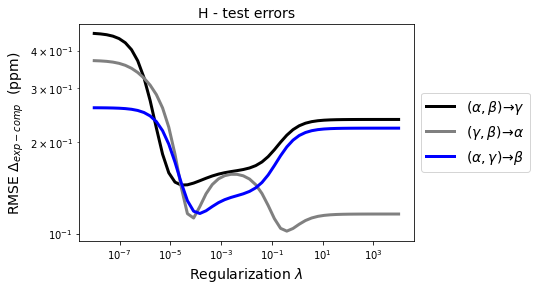

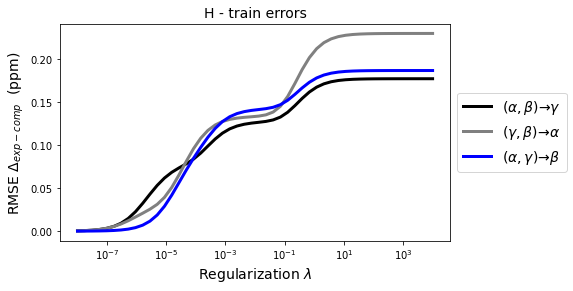

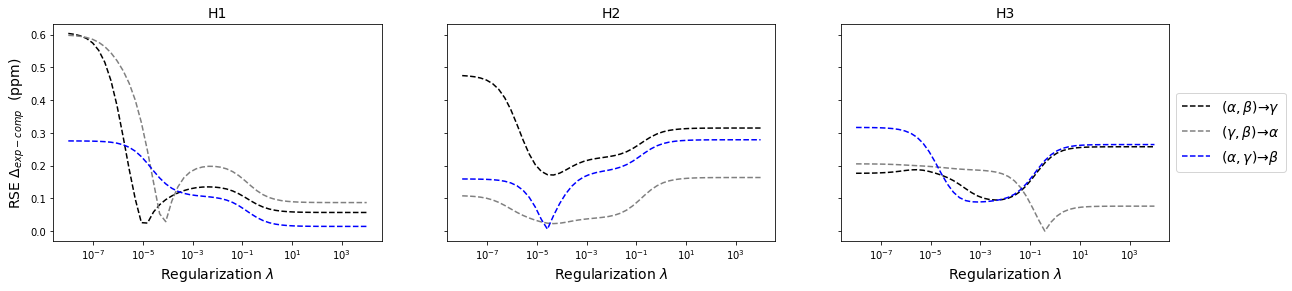

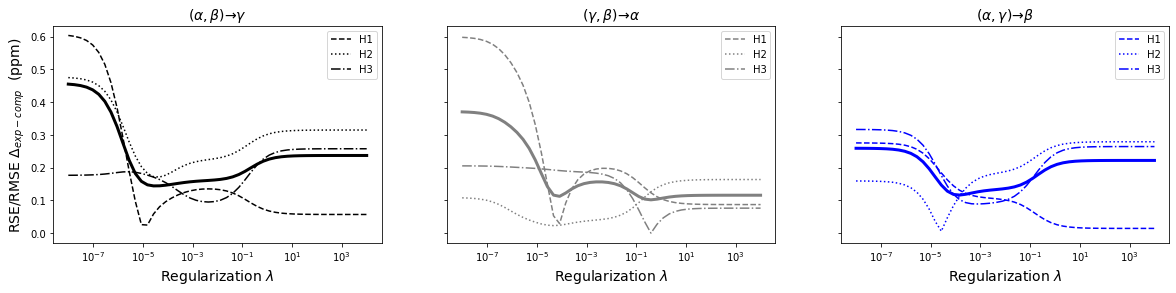

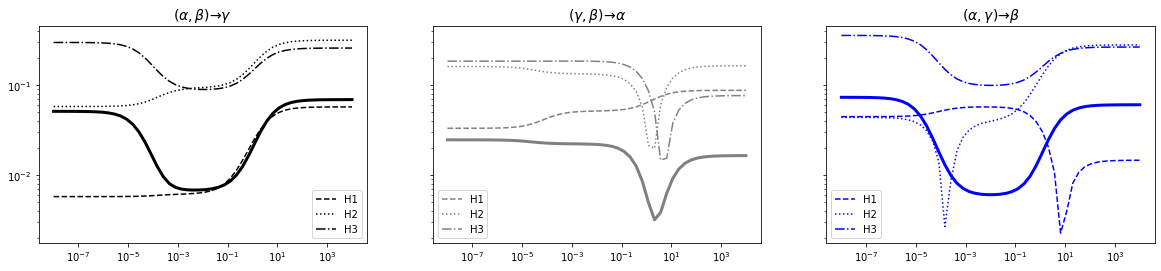

In [101]:
species = sp
print(species)

# compute compuational shifts from shieldings (similarly to Edgars paper)

csh_alpha_1 = cs_alpha_1.mean() - cs_alpha_1
csh_gamma_1 = cs_gamma_1.mean() - cs_gamma_1
csh_beta_1 = cs_beta_1.mean() - cs_beta_1


# compute deltas (difference between experimental and computational)

delta_alpha_1 = shifts['glycine_alpha'][species] - csh_alpha_1
delta_gamma_1 = shifts['glycine_gamma'][species] - csh_gamma_1
delta_beta_1 = shifts['glycine_beta'][species] - csh_beta_1


# compute RMSE for all three folds

alphas, errors_gamma, errors_gamma_sep, errors_gamma_sep_sep, errors_train_gamma  = pred_3_folds(np.array([*X_alpha_1, *X_beta_1]), X_gamma_1, np.array([*delta_alpha_1, *delta_beta_1]).reshape(-1, 1), delta_gamma_1.reshape(-1, 1))
_ , errors_alpha, errors_alpha_sep, errors_alpha_sep_sep, errors_train_alpha   = pred_3_folds(np.array([*X_gamma_1, *X_beta_1]), X_alpha_1, np.array([*delta_gamma_1, *delta_beta_1]).reshape(-1, 1), delta_alpha_1.reshape(-1, 1))
_ , errors_beta, errors_beta_sep, errors_beta_sep_sep, errors_train_beta   = pred_3_folds(np.array([*X_alpha_1, *X_gamma_1]), X_beta_1, np.array([*delta_alpha_1, *delta_gamma_1]).reshape(-1, 1), delta_beta_1.reshape(-1, 1))


final_error_gamma = pred_3_folds_validated(np.array([*X_alpha_1, *X_beta_1]), X_gamma_1, np.array([*delta_alpha_1, *delta_beta_1]).reshape(-1, 1), delta_gamma_1.reshape(-1, 1))
final_error_alpha = pred_3_folds_validated(np.array([*X_gamma_1, *X_beta_1]), X_alpha_1, np.array([*delta_gamma_1, *delta_beta_1]).reshape(-1, 1), delta_alpha_1.reshape(-1, 1))
final_error_beta  = pred_3_folds_validated(np.array([*X_alpha_1, *X_gamma_1]), X_beta_1, np.array([*delta_alpha_1, *delta_gamma_1]).reshape(-1, 1), delta_beta_1.reshape(-1, 1))


# draw figure for all three folds for the RMSE

plt.plot(alphas, errors_gamma, label=r'$(\alpha, \beta) \to \gamma$', color=colors[0], linewidth = 3.0)
plt.plot(alphas, errors_alpha, label=r'$(\gamma, \beta)\to \alpha$',  color=colors[1], linewidth = 3.0)
plt.plot(alphas, errors_beta, label=r'$(\alpha, \gamma) \to \beta$', color=colors[2], linewidth = 3.0)

plt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("H - test errors", fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

print("ALPHA: " + str(min(errors_alpha)) + " - "+  str(max(errors_alpha)) + "  RMSE:  " + str(final_error_alpha) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_alpha_1.shape),delta_alpha_1))))
print("BETA: " + str(min(errors_beta)) + " - "+  str(max(errors_beta)) + "  RMSE:  " + str(final_error_beta) +   " BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_beta_1.shape),delta_beta_1))))
print("GAMMA: " + str(min(errors_gamma)) + " - "+  str(max(errors_gamma)) + "  RMSE:  " + str(final_error_gamma) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_gamma_1.shape),delta_gamma_1))))

figt, axt = plt.subplots(ncols=1, nrows=1, sharey=True)
figt.set_figheight(4)
figt.set_figwidth(7)

axt.plot(alphas, errors_train_gamma, label=r'$(\alpha, \beta) \to \gamma$', color=colors[0], linewidth = 3.0)
axt.plot(alphas, errors_train_alpha, label=r'$(\gamma, \beta)\to \alpha$',  color=colors[1], linewidth = 3.0)
axt.plot(alphas, errors_train_beta, label=r'$(\alpha, \gamma) \to \beta$', color=colors[2], linewidth = 3.0)

axt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
axt.set_title("H - train errors", fontsize=14)
axt.set_xscale("log")
axt.set_xlabel(r"Regularization $\lambda$", fontsize=14)
axt.set_ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)


# draw figure separately for different shieldings

fig, ax = plt.subplots(ncols=len(delta_alpha_1), nrows=1, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(20)

for i in range(len(delta_alpha_1)):
    ax[i].plot(alphas, errors_gamma_sep[:, i], color=colors[0], linestyle="dashed", label=r'$(\alpha, \beta) \to \gamma$')
    ax[i].plot(alphas, errors_alpha_sep[:, i], color=colors[1], linestyle="dashed", label = r'$(\gamma, \beta)\to \alpha$')
    ax[i].plot(alphas, errors_beta_sep[:, i], color=colors[2], linestyle="dashed", label = r'$(\alpha, \gamma) \to \beta$')
    ax[i].set_title("H" + str(i + 1), fontsize=14)
    ax[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
    ax[i].set_xscale("log")
ax[0].set_ylabel(r"RSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)
ax[2].legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

# draw figure separately for different crossvalidation folds

fig1, ax1 = plt.subplots(ncols=len(delta_alpha_1), nrows=1, sharey=True)
fig1.set_figheight(4)
fig1.set_figwidth(20)

linestyles = ["dashed", "dotted", "dashdot"]

errors_ave = [errors_gamma, errors_alpha, errors_beta]
errors_shield = [errors_gamma_sep, errors_alpha_sep, errors_beta_sep]
names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']

for i in range(len(errors_ave)):
    ax1[i].plot(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha_1)):
        ax1[i].plot(alphas, errors_shield[i][:, j], color=colors[i], linestyle=linestyles[j], label = "H" + str(j + 1))
    ax1[i].set_title(names[i], fontsize=14)
    ax1[i].legend()
    ax1[i].set_xscale("log")
    ax1[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax1[0].set_ylabel(r"RSE/RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

# Draw figure for separated shieldings models

fig2, ax2 = plt.subplots(ncols=len(delta_alpha_1), nrows=1, sharey=True)
fig2.set_figheight(4)
fig2.set_figwidth(20)

errors_ave = []
errors_shield = [errors_gamma_sep_sep, errors_alpha_sep_sep, errors_beta_sep_sep]

for i in errors_shield:     
    errors_ave.append(np.sqrt(np.mean([j**4 for j in i], 1)))

names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']



for i in range(len(errors_ave)):
    ax2[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha_1)):
        ax2[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle=linestyles[j], label = "H" + str(j + 1))
    ax2[i].set_title(names[i], fontsize=14)
    ax2[i].legend()
a = 1


Text(0, 0.5, 'RMSE $\\Delta_{exp - comp}$  (ppm)')

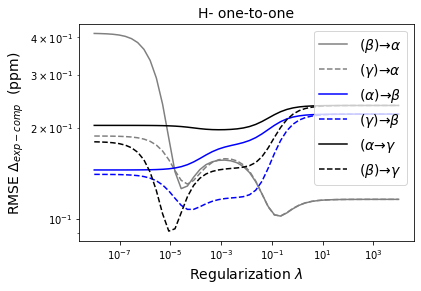

In [119]:
species = 1

csh_alpha_1 = cs_alpha_1.mean() - cs_alpha_1
csh_gamma_1 = cs_gamma_1.mean() - cs_gamma_1
csh_beta_1 = cs_beta_1.mean() - cs_beta_1


delta_alpha_1 = shifts['glycine_alpha'][species] - csh_alpha_1
delta_gamma_1 = shifts['glycine_gamma'][species] - csh_gamma_1
delta_beta_1 = shifts['glycine_beta'][species] - csh_beta_1


alphas, errors_alpha_gamma, _, _ ,_ = pred_3_folds(X_alpha_1, X_gamma_1, delta_alpha_1.reshape(-1, 1), delta_gamma_1.reshape(-1, 1),False)
_ , errors_alpha_beta, _, _ ,_= pred_3_folds(X_alpha_1, X_beta_1, delta_alpha_1.reshape(-1, 1),  delta_beta_1.reshape(-1, 1),False)
_ , errors_alpha_beta, _, _ ,_= pred_3_folds(X_alpha_1, X_beta_1, delta_alpha_1.reshape(-1, 1),  delta_beta_1.reshape(-1, 1),False)
_ , errors_beta_alpha, _, _,_= pred_3_folds(X_beta_1, X_alpha_1, delta_beta_1.reshape(-1, 1), delta_alpha_1.reshape(-1, 1),False)
_ , errors_beta_gamma, _, _ ,_= pred_3_folds(X_beta_1, X_gamma_1, delta_beta_1.reshape(-1, 1), delta_gamma_1.reshape(-1, 1),False)
_ , errors_gamma_alpha, _, _,_= pred_3_folds(X_gamma_1, X_alpha_1, delta_gamma_1.reshape(-1, 1), delta_alpha_1.reshape(-1, 1),False)
_ , errors_gamma_beta, _, _,_= pred_3_folds(X_gamma_1, X_beta_1, delta_gamma_1.reshape(-1, 1), delta_beta_1.reshape(-1, 1),False)


plt.loglog(alphas, errors_beta_alpha, label=r'$(\beta) \to \alpha$', color=colors[1])
plt.loglog(alphas, errors_gamma_alpha, label=r'$(\gamma) \to \alpha$', color=colors[1], linestyle="dashed")
plt.loglog(alphas, errors_alpha_beta, label=r'$(\alpha) \to \beta$', color=colors[2])
plt.loglog(alphas, errors_gamma_beta, label=r'$(\gamma) \to \beta$', color=colors[2], linestyle="dashed")
plt.loglog(alphas, errors_alpha_gamma, label=r'$(\alpha \to \gamma$', color=colors[0])
plt.loglog(alphas, errors_beta_gamma, label=r'$(\beta) \to \gamma$', color=colors[0], linestyle="dashed")

plt.legend(fontsize=14)
plt.title("H- one-to-one", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

In [103]:
compound = "glycine"
sp = 6

with open('/home/lumiaro/Documents/master_project/average_trajectories/glycine_test/glycine_models/' + compound + '_' + str(sp) + '.pickle','rb') as f:
    [soap, kern, feat, weig, alpha] = pickle.load(f)

X = feat.get_features()
zeta = kern._kwargs["zeta"]


# download and average SOAPs and shieldings for all three glycines
cs_alpha_6, X_alpha_6, cs_alpha_6_dict, X_alpha_6_dict = process(alpha_traj, alpha_shieldings, soap, sp, X, zeta)
cs_beta_6, X_beta_6, cs_beta_6_dict, X_beta_6_dict = process(beta_traj, beta_shieldings, soap, sp, X, zeta)
cs_gamma_6, X_gamma_6, cs_gamma_6_dict, X_gamma_6_dict = process(gamma_traj, gamma_shieldings, soap, sp, X, zeta)


In [104]:
path_to_files = "3_fold_model_files/"

# save our averaged_results
np.save(path_to_files + "Averaged_kernel_alpha_6.npy", X_alpha_6)
np.save(path_to_files + "Averaged_kernel_beta_6.npy", X_beta_6)
np.save(path_to_files + "Averaged_kernel_gamma_6.npy", X_gamma_6)

np.savetxt(path_to_files + "Averaged_cs_alpha_6.txt", cs_alpha_6)
np.savetxt(path_to_files + "Averaged_cs_beta_6.txt", cs_beta_6)
np.savetxt(path_to_files + "Averaged_cs_gamma_6.txt", cs_gamma_6)

with open("3_fold_model_files/Averaged_kernel_alpha_6_separated.pkl", 'wb') as f:
    pickle.dump(X_alpha_6_dict, f)

with open("3_fold_model_files/Averaged_kernel_beta_6_separated.pkl", 'wb') as f:
    pickle.dump(X_beta_6_dict, f)

with open("3_fold_model_files/Averaged_kernel_gamma_6_separated.pkl", 'wb') as f:
    pickle.dump(X_gamma_6_dict, f)

with open("3_fold_model_files/Averaged_cs_alpha_6_separated.pkl", 'wb') as f:
    pickle.dump(cs_alpha_6_dict, f)

with open("3_fold_model_files/Averaged_cs_beta_6_separated.pkl", 'wb') as f:
    pickle.dump(cs_beta_6_dict, f)

with open("3_fold_model_files/Averaged_cs_gamma_6_separated.pkl", 'wb') as f:
    pickle.dump(cs_gamma_6_dict, f)

In [ ]:
# load stuff
path_to_files = "3_fold_model_files/"

X_alpha_6 = np.load(path_to_files + "Averaged_kernel_alpha_6.npy")
X_beta_6= np.load(path_to_files + "Averaged_kernel_beta_6.npy")
X_gamma_6 = np.load(path_to_files + "Averaged_kernel_gamma_6.npy")

cs_alpha_6 = np.loadtxt(path_to_files + "Averaged_cs_alpha_6.txt")
cs_beta_6 = np.loadtxt(path_to_files + "Averaged_cs_beta_6.txt")
cs_gamma_6 = np.loadtxt(path_to_files + "Averaged_cs_gamma_6.txt")

with open(path_to_files + "Averaged_kernel_alpha_6_separated.pkl", 'rb') as f:
    X_alpha_6_dict = pickle.load(f)

with open(path_to_files + "Averaged_kernel_beta_6_separated.pkl", 'rb') as f:
    X_beta_6_dict = pickle.load(f)

with open(path_to_files + "Averaged_kernel_gamma_6_separated.pkl", 'rb') as f:
    X_gamma_6_dict = pickle.load(f)

with open(path_to_files + "Averaged_cs_alpha_6_separated.pkl", 'rb') as f:
    cs_alpha_6_dict = pickle.load(f)

with open(path_to_files + "Averaged_cs_beta_6_separated.pkl", 'rb') as f:
    cs_beta_6_dict = pickle.load(f)

with open(path_to_files + "Averaged_cs_gamma_6_separated.pkl", 'rb') as f:
    cs_gamma_6_dict = pickle.load(f)

6
ALPHA: 0.17808501144493025 - 0.929149508457866  RMSE:  0.2894430492350043   BASELINE: 0.929179324832873
BETA: 0.014836983731595999 - 0.7225005295342232  RMSE:  0.05616059921139828 BASELINE: 0.7225348842173389
GAMMA: 0.018172201131071097 - 0.6267128190226886  RMSE:  0.13262033174320884   BASELINE: 0.6267494066306654


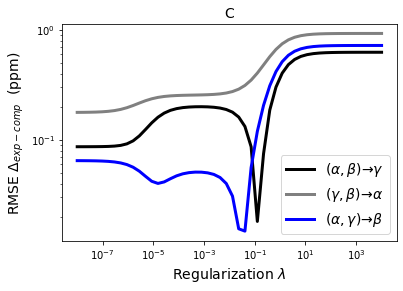

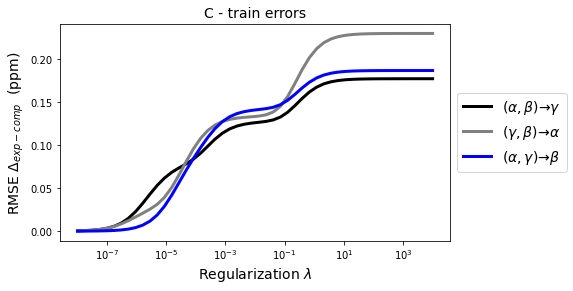

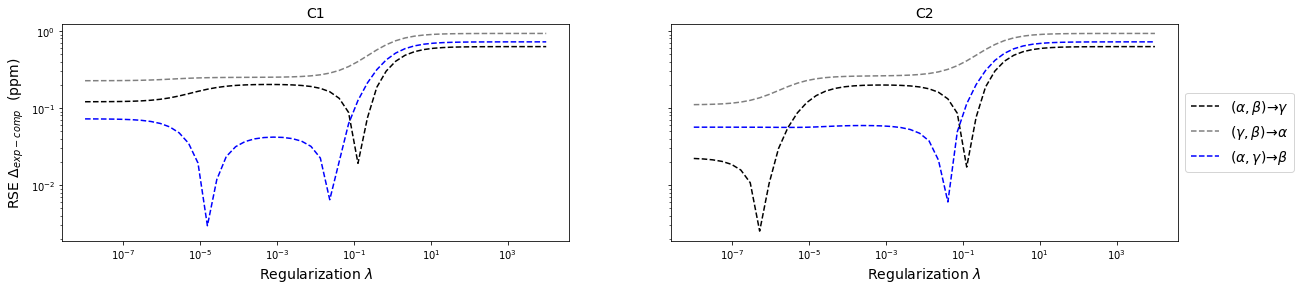

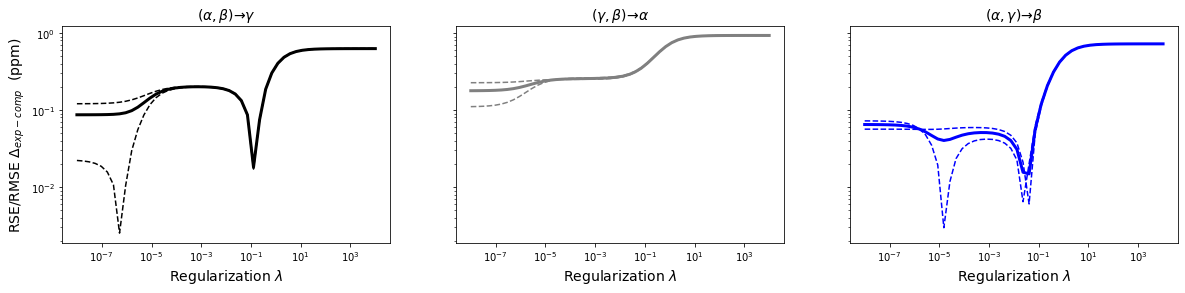

In [115]:
species = sp
print(species)

csh_alpha_6 = cs_alpha_6.mean() - cs_alpha_6
csh_gamma_6 = cs_gamma_6.mean() - cs_gamma_6
csh_beta_6 = cs_beta_6.mean() - cs_beta_6


delta_alpha_6 = shifts['glycine_alpha'][species] - csh_alpha_6
delta_gamma_6 = shifts['glycine_gamma'][species] - csh_gamma_6
delta_beta_6 = shifts['glycine_beta'][species] - csh_beta_6

alphas, errors_gamma, errors_gamma_sep, errors_gamma_sep_sep, errors_gamma_train  = pred_3_folds(np.array([*X_alpha_6, *X_beta_6]), X_gamma_6, np.array([*delta_alpha_6, *delta_beta_6]).reshape(-1, 1), delta_gamma_6.reshape(-1, 1))
_ , errors_alpha, errors_alpha_sep, errors_alpha_sep_sep, errors_alpha_train  = pred_3_folds(np.array([*X_gamma_6, *X_beta_6]), X_alpha_6, np.array([*delta_gamma_6, *delta_beta_6]).reshape(-1, 1), delta_alpha_6.reshape(-1, 1))
_ , errors_beta, errors_beta_sep, errors_beta_sep_sep, errors_beta_train  = pred_3_folds(np.array([*X_alpha_6, *X_gamma_6]), X_beta_6, np.array([*delta_alpha_6, *delta_gamma_6]).reshape(-1, 1), delta_beta_6.reshape(-1, 1))

plt.loglog(alphas, errors_gamma, label=r'$(\alpha, \beta) \to \gamma$', color=colors[0], linewidth = 3.0)
plt.loglog(alphas, errors_alpha, label=r'$(\gamma, \beta)\to \alpha$',  color=colors[1], linewidth = 3.0)
plt.loglog(alphas, errors_beta, label=r'$(\alpha, \gamma) \to \beta$', color=colors[2], linewidth = 3.0)

final_error_gamma = pred_3_folds_validated(np.array([*X_alpha_6, *X_beta_6]), X_gamma_6, np.array([*delta_alpha_6, *delta_beta_6]).reshape(-1, 1), delta_gamma_6.reshape(-1, 1))
final_error_alpha = pred_3_folds_validated(np.array([*X_gamma_6, *X_beta_6]), X_alpha_6, np.array([*delta_gamma_6, *delta_beta_6]).reshape(-1, 1), delta_alpha_6.reshape(-1, 1))
final_error_beta  = pred_3_folds_validated(np.array([*X_alpha_6, *X_gamma_6]), X_beta_6, np.array([*delta_alpha_6, *delta_gamma_6]).reshape(-1, 1), delta_beta_6.reshape(-1, 1))

plt.legend(fontsize=14)
plt.title("C", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

print("ALPHA: " + str(min(errors_alpha)) + " - "+  str(max(errors_alpha)) + "  RMSE:  " + str(final_error_alpha) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_alpha_6.shape),delta_alpha_6))))
print("BETA: " + str(min(errors_beta)) + " - "+  str(max(errors_beta)) + "  RMSE:  " + str(final_error_beta) +   " BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_beta_6.shape),delta_beta_6))))
print("GAMMA: " + str(min(errors_gamma)) + " - "+  str(max(errors_gamma)) + "  RMSE:  " + str(final_error_gamma) + "   BASELINE: " + str(np.sqrt(mean_squared_error(np.zeros(delta_gamma_6.shape),delta_gamma_6))))

figt, axt = plt.subplots(ncols=1, nrows=1, sharey=True)
figt.set_figheight(4)
figt.set_figwidth(7)

axt.plot(alphas, errors_train_gamma, label=r'$(\alpha, \beta) \to \gamma$', color=colors[0], linewidth = 3.0)
axt.plot(alphas, errors_train_alpha, label=r'$(\gamma, \beta)\to \alpha$',  color=colors[1], linewidth = 3.0)
axt.plot(alphas, errors_train_beta, label=r'$(\alpha, \gamma) \to \beta$', color=colors[2], linewidth = 3.0)

axt.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))
axt.set_title("C - train errors", fontsize=14)
axt.set_xscale("log")
axt.set_xlabel(r"Regularization $\lambda$", fontsize=14)
axt.set_ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

# draw figure separately for different shieldings

fig, ax = plt.subplots(ncols=len(delta_alpha_6), nrows=1, sharey=True)
fig.set_figheight(4)
fig.set_figwidth(20)

for i in range(len(delta_alpha_6)):
    ax[i].loglog(alphas, errors_gamma_sep[:, i], color=colors[0], linestyle="dashed", label=r'$(\alpha, \beta) \to \gamma$')
    ax[i].loglog(alphas, errors_alpha_sep[:, i], color=colors[1], linestyle="dashed", label = r'$(\gamma, \beta)\to \alpha$')
    ax[i].loglog(alphas, errors_beta_sep[:, i], color=colors[2], linestyle="dashed", label = r'$(\alpha, \gamma) \to \beta$')
    ax[i].set_title("C" + str(i + 1), fontsize=14)
    ax[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax[0].set_ylabel(r"RSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)
ax[1].legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

# draw figure separately for different crossvalidation folds

fig1, ax1 = plt.subplots(ncols=3, nrows=1, sharey=True)
fig1.set_figheight(4)
fig1.set_figwidth(20)

errors_ave = [errors_gamma, errors_alpha, errors_beta]
errors_shield = [errors_gamma_sep, errors_alpha_sep, errors_beta_sep]
names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']

for i in range(len(errors_ave)):
    ax1[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha_6)):
        ax1[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle="dashed")
    ax1[i].set_title(names[i], fontsize=14)
    ax1[i].set_xlabel(r"Regularization $\lambda$", fontsize=14)
ax1[0].set_ylabel(r"RSE/RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

# Draw figure for separated shieldings models
"""
fig2, ax2 = plt.subplots(ncols=len(delta_alpha), nrows=1, sharey=True)
fig2.set_figheight(4)
fig2.set_figwidth(20)

errors_ave = []
errors_shield = [errors_gamma_sep_sep, errors_alpha_sep_sep, errors_beta_sep_sep]

for i in errors_shield:     
    errors_ave.append(np.sqrt(np.mean([j**4 for j in i], 1)))

names = [r'$(\alpha, \beta) \to \gamma$', r'$(\gamma, \beta)\to \alpha$', r'$(\alpha, \gamma) \to \beta$']

for i in range(len(errors_ave)):
    ax2[i].loglog(alphas, errors_ave[i], color=colors[i], linewidth = 3.0)
    for j in range(len(delta_alpha)):
        ax2[i].loglog(alphas, errors_shield[i][:, j], color=colors[i], linestyle="dashed")
    ax2[i].set_title(names[i], fontsize=14)
"""
a = 1


Text(0, 0.5, 'RMSE $\\Delta_{exp - comp}$  (ppm)')

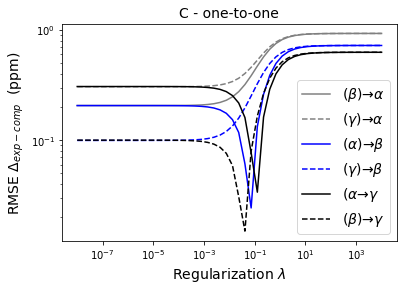

In [118]:
species = 6

csh_alpha = cs_alpha_6.mean() - cs_alpha_6
csh_gamma = cs_gamma_6.mean() - cs_gamma_6
csh_beta = cs_beta_6.mean() - cs_beta_6


delta_alpha_6 = shifts['glycine_alpha'][species] - csh_alpha_6
delta_gamma_6 = shifts['glycine_gamma'][species] - csh_gamma_6
delta_beta_6 = shifts['glycine_beta'][species] - csh_beta_6


alphas, errors_alpha_gamma, _, _,_ = pred_3_folds(X_alpha_6, X_gamma_6, delta_alpha_6.reshape(-1, 1), delta_gamma_6.reshape(-1, 1),False)
_ , errors_alpha_beta, _, _,_  = pred_3_folds(X_alpha_6, X_beta_6, delta_alpha_6.reshape(-1, 1),  delta_beta_6.reshape(-1, 1),False)
_ , errors_beta_alpha, _, _,_ = pred_3_folds(X_beta_6, X_alpha_6, delta_beta_6.reshape(-1, 1), delta_alpha_6.reshape(-1, 1),False)
_ , errors_beta_gamma, _, _ ,_ = pred_3_folds(X_beta_6, X_gamma_6, delta_beta_6.reshape(-1, 1), delta_gamma_6.reshape(-1, 1),False)
_ , errors_gamma_alpha, _, _,_ = pred_3_folds(X_gamma_6, X_alpha_6, delta_gamma_6.reshape(-1, 1), delta_alpha_6.reshape(-1, 1),False)
_ , errors_gamma_beta, _, _,_ = pred_3_folds(X_gamma_6, X_beta_6, delta_gamma_6.reshape(-1, 1), delta_beta_6.reshape(-1, 1),False)


plt.loglog(alphas, errors_beta_alpha, label=r'$(\beta) \to \alpha$', color=colors[1])
plt.loglog(alphas, errors_gamma_alpha, label=r'$(\gamma) \to \alpha$', color=colors[1], linestyle="dashed")
plt.loglog(alphas, errors_alpha_beta, label=r'$(\alpha) \to \beta$', color=colors[2])
plt.loglog(alphas, errors_gamma_beta, label=r'$(\gamma) \to \beta$', color=colors[2], linestyle="dashed")
plt.loglog(alphas, errors_alpha_gamma, label=r'$(\alpha \to \gamma$', color=colors[0])
plt.loglog(alphas, errors_beta_gamma, label=r'$(\beta) \to \gamma$', color=colors[0], linestyle="dashed")

plt.legend(fontsize=14)
plt.title("C - one-to-one", fontsize=14)
plt.xlabel(r"Regularization $\lambda$", fontsize=14)
plt.ylabel(r"RMSE $\Delta_{exp - comp}$  (ppm)", fontsize=14)

6


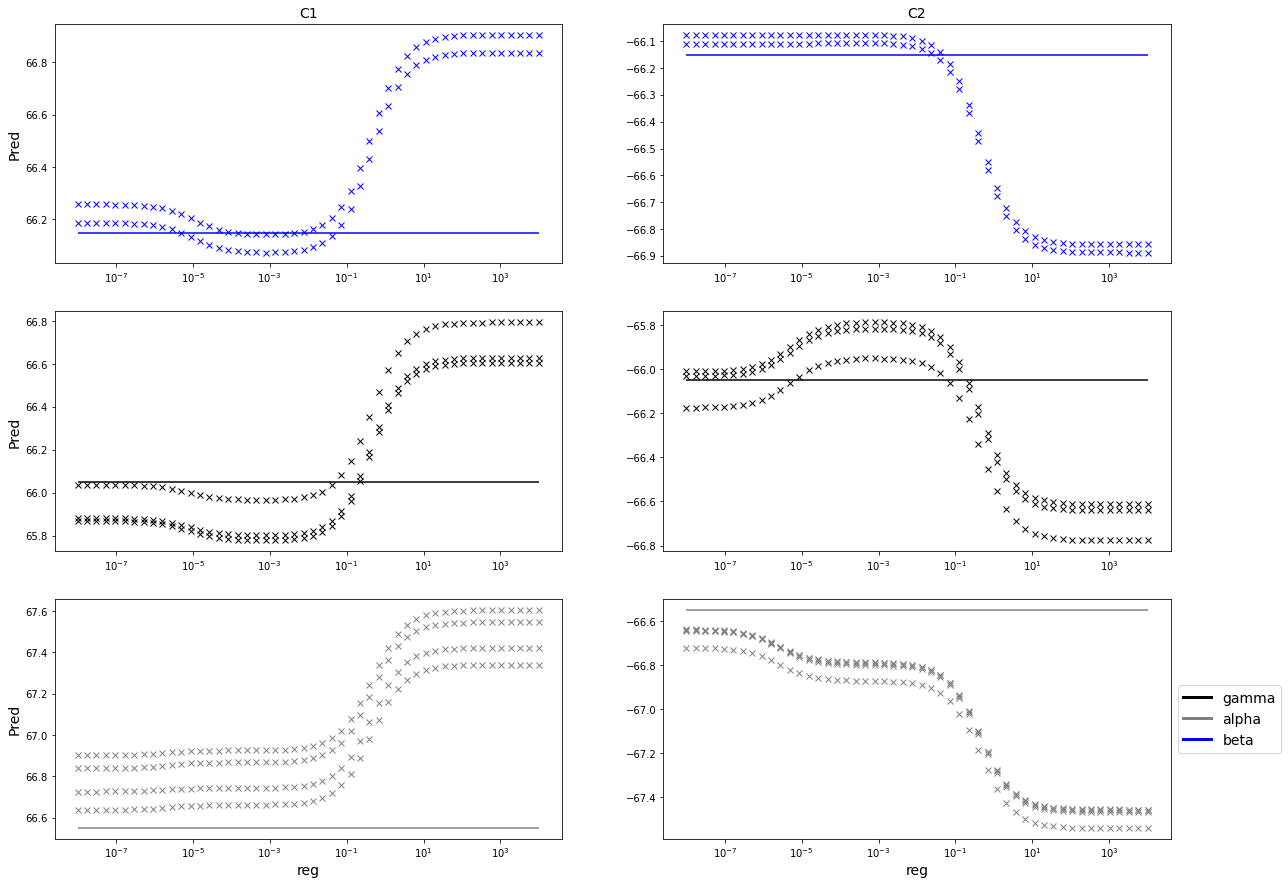

In [113]:
species = sp
print(species)

colors = ['k','grey','b','r', "pink"]

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],color=c, lw=3) for c in colors]

# compute compuational shifts from shieldings (similarly to Edgars paper)

csh_alpha_6 = cs_alpha_6.mean() - cs_alpha_6
csh_gamma_6 = cs_gamma_6.mean() - cs_gamma_6
csh_beta_6 = cs_beta_6.mean() - cs_beta_6

delta_alpha_6 = shifts['glycine_alpha'][species] - csh_alpha_6
delta_gamma_6 = shifts['glycine_gamma'][species] - csh_gamma_6
delta_beta_6 = shifts['glycine_beta'][species] - csh_beta_6

def shifts_alpha(alpha, type):
    pred_shifts_gamma = pred_model(np.array([*X_alpha_6, *X_beta_6]), X_gamma_6_dict[type], np.array([*delta_alpha_6, *delta_beta_6]).reshape(-1, 1), alpha).reshape(-1)
    pred_shifts_gamma += cs_gamma_6.mean() - cs_gamma_6_dict[type]

    pred_shifts_alpha = pred_model(np.array([*X_gamma_6, *X_beta_6]), X_alpha_6_dict[type], np.array([*delta_gamma_6, *delta_beta_6]).reshape(-1, 1), alpha).reshape(-1)
    pred_shifts_alpha += cs_alpha_6.mean() - cs_alpha_6_dict[type]

    pred_shifts_beta = pred_model(np.array([*X_alpha_6, *X_gamma_6]), X_beta_6_dict[type], np.array([*delta_alpha_6, *delta_gamma_6]).reshape(-1, 1), alpha).reshape(-1)
    pred_shifts_beta += cs_beta_6.mean() -  cs_beta_6_dict[type]

    return pred_shifts_beta, pred_shifts_alpha, pred_shifts_gamma

fig1, ax1 = plt.subplots(ncols=len(delta_alpha_6), nrows=3)
fig1.set_figheight(15)
fig1.set_figwidth(20)

alphas = np.logspace(-8, 4)

for i in range(2):
    for alpha in  alphas:
        pred_shifts_beta, pred_shifts_alpha, pred_shifts_gamma = shifts_alpha(alpha, i + 1)
        ax1[0][i].plot(alpha*np.ones(pred_shifts_beta.shape), pred_shifts_beta, "x", color= colors[2])
        ax1[1][i].plot(alpha*np.ones(pred_shifts_gamma.shape), pred_shifts_gamma, "x", color= colors[0])
        ax1[2][i].plot(alpha*np.ones(pred_shifts_alpha.shape), pred_shifts_alpha, "x", color= colors[1])
    ax1[0][i].hlines(shifts['glycine_beta'][species][i], min(alphas), max(alphas), colors[2])
    ax1[1][i].hlines( shifts['glycine_gamma'][species][i], min(alphas), max(alphas), colors[0])
    ax1[2][i].hlines(shifts['glycine_alpha'][species][i], min(alphas), max(alphas) , colors[1])
    ax1[0][i].set_title("C" + str(i + 1), fontsize=14)
    ax1[2][i].set_xlabel(r"reg", fontsize=14)
    ax1[0][i].set_xscale("log")
    ax1[1][i].set_xscale("log")
    ax1[2][i].set_xscale("log")
ax1[0][0].set_ylabel(r"Pred", fontsize=14)
ax1[1][0].set_ylabel(r"Pred", fontsize=14)
ax1[2][0].set_ylabel(r"Pred", fontsize=14)
ax1[2][1].legend(custom_lines, [ "gamma", "alpha", "beta"], fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))



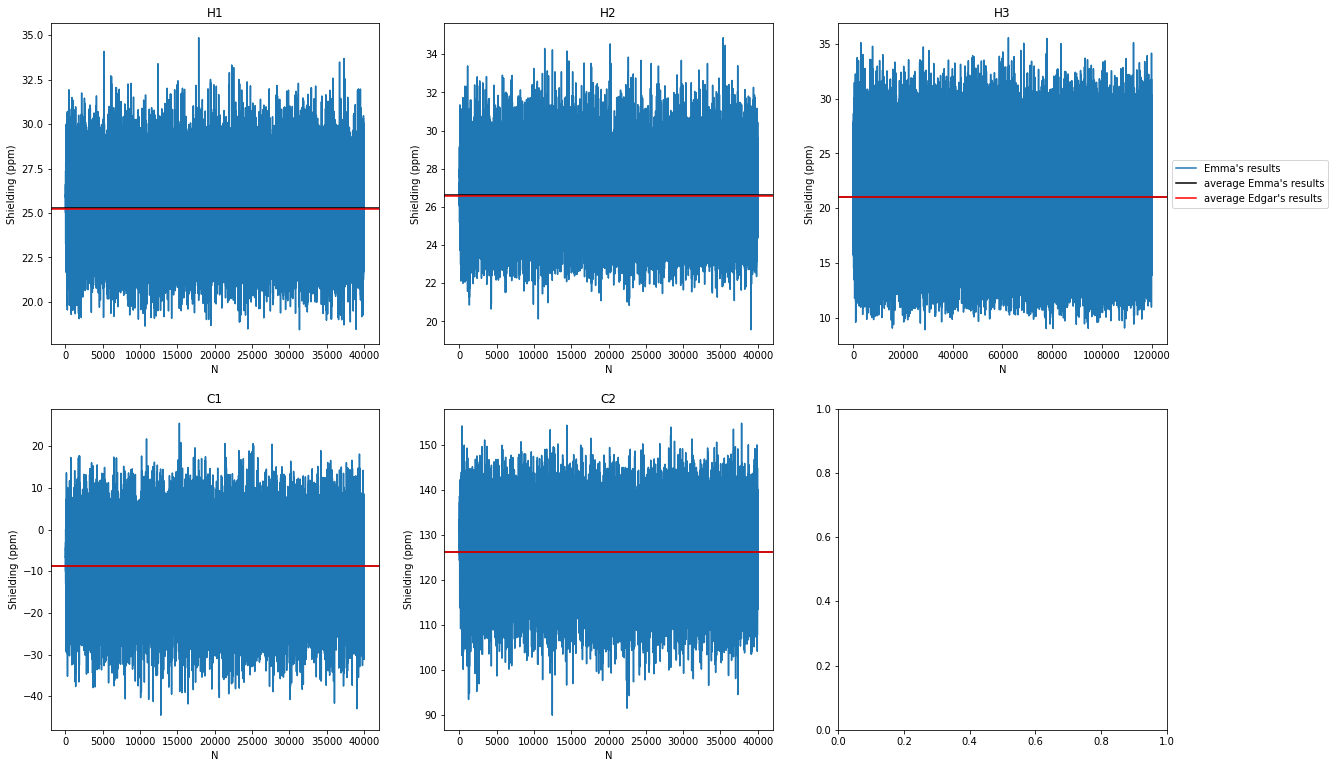

In [201]:
fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_figheight(13)
fig.set_figwidth(20)

edgars_results = {
    'glycine_alpha': {
        1 : np.array([25.24, 26.59, 21.07]),
        6 : np.array([-8.64, 126.26]),
        7 : np.array([191.82])
    },
    'glycine_beta': {
        1: np.array([26.13, 26.91, 21.16]),
        6: np.array([-5.73, 127.86]),
        7: np.array([194.45])
    },
    'glycine_gamma': {
        1 : np.array([26.53, 27.11, 20.86]),
        6 : np.array([-5.01, 128.34]),
        7 : np.array([191.37])
    }
}

edgars_errors = {
    'glycine_alpha': {
        1 : np.array([0.02, 0.02, 0.01]),
        6 : np.array([0.08, 0.07]),
        7 : np.array([0.15])
    },
    'glycine_beta': {
        1: np.array([0.25, 0.26, 0.21]),
        6: np.array([0.58, 0.64]),
        7: np.array([1.29])
    },
    'glycine_gamma': {
        1 : np.array([0.02, 0.02, 0.01]),
        6 : np.array([0.02, 0.02]),
        7 : np.array([0.01])
    }
}

labels = {1 : "H", 6: "C", 7 : "N", 8 : "O"}

for i, el in enumerate([1,6]):
    for j in range(len(edgars_results["glycine_alpha"][el])):
        cs = np.concatenate([frame.arrays['CS'][np.where(np.logical_and(frame.numbers==el, alpha_shieldings == j + 1))[0]] for frame in alpha_traj])
        ax[i][j].plot(cs, label="Emma's results")
        ax[i][j].axhline(np.mean(cs), c='k', label="average Emma's results")
        ax[i][j].axhline(edgars_results["glycine_alpha"][el][j], c='r', label="average Edgar's results")
        ax[i][j].set_title(labels[el] + str(j + 1))
        ax[i][j].set_ylabel("Shielding (ppm)")
        ax[i][j].set_xlabel("N")
        #ax[i][j].fill_between(range(len(cs[np.where(types==1)])), 25.22, 25.26, color='r', alpha=0.5)
ax[0][2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

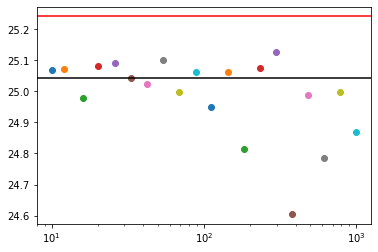

In [71]:
for j in np.logspace(1, 3, 20, dtype=int):
    plt.scatter(j, np.mean(cs[np.where(types==1)][10*j::j]))
plt.axhline(25.24, c='r')
plt.axhline(np.mean(cs[np.where(types==1)]), c='k')
plt.gca().set_xscale('log')